<a href="https://colab.research.google.com/github/benza613/Sentiment-Analysis-using-Deep-Learning/blob/master/notebooks/model_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# create a notebook for LSTM prediction model 

# 1. Load the chosen dataset and try to see the vocab size 
# 2. Determine a MAX_VOCAB_SIZE incase you observe a vocab dict that is too large (choose the top/most frequent MAX_VOCAB_SIZE entries / Curse of dimensionality)
# 3. Determine a MAX_SEQUENCE LENGTH to vectorize for each review (Note: From splitter usually reviews will be limited to 400 + summary )

# DO NOT EDIT/ DELETE THIS BLOCK;



In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# set working directory -> you must set the path into which you have uploaded the zipped file
# this is required in the case of colab or local 
%cd /content/drive/My\ Drive/SNLP\ Project
# %cd Source/repos/Sentiment-Analysis-using-Deep-Learning

[Errno 2] No such file or directory: '/content/drive/My Drive/SNLP Project'
/content/drive/My Drive/SNLP/Sentiment-Analysis-using-Deep-Learning


In [10]:
# list content of drive - verify you are where you are supposed to be
%ls

 All_Beauty_5.json.gz
 all_beauty.npy
 Appliances.json.gz
 Appliances.npy
 Baseline/
 baseline.csv
 BTest_20000_Apr-19-2020_22-50.csv
 BTest_2000_Apr-19-2020_22-50.csv
 BTrain_2000_Apr-19-2020_22-40.csv
 BTrain_2000_Apr-19-2020_22-50.csv
 CleantData_Apr-03-2020_23-16.zip
 CleantData_Apr-19-2020_22-22.zip
 CleantData_Apr-22-2020_01-35.csv
 CleantData_Apr-22-2020_01-35.zip
'CleantData_Apr-22-2020_01-35.zip (Unzipped Files)'/
 data/
 Data_Balanced_20000_Apr-22-2020_01-39/
 Data_Balanced_5300_Apr-27-2020_04-43/
 data_pos_neg/
 Electronics_5.json.gz
 electronics_5.npy
 glove.6B/
 glove.840B.300d/
 glove.840B.300d.zip
 ModelResults/
 notebookrj/
 notebooks/
 README.md
 review2/
'Sentiment Analysis - Deep Learning (1).pptx'
 Test_100000_Apr-19-2020_22-33.csv
 Test_20000_Apr-19-2020_22-50.csv
 Test_2000_Apr-19-2020_22-40.csv
 test_baseline.csv
 Train_100000_Apr-19-2020_22-33.csv
 Train_20000_Apr-19-2020_22-50.csv
 Train_2000_Apr-19-2020_22-40.csv
 train_baseline.csv


In [11]:
# load your choice of dataset here . Specify paths as folder_datestring/file_datestring.zip
Train_ZipCSVFileName = 'amz_all_electronics/Data_Balanced_2000_Apr-03-2020_06-46/Train_2000_Apr-03-2020_06-46.zip'
Test_ZipCSVFileName = 'amz_all_electronics/Data_Balanced_2000_Apr-03-2020_06-46/Test_2000_Apr-03-2020_06-46.zip'

import pandas as pd
import numpy as np


df_train = pd.read_csv(Train_ZipCSVFileName)
df_train.info()

df_test = pd.read_csv(Test_ZipCSVFileName)
df_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3759 entries, 0 to 3758
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         3759 non-null   float64
 1   reviewTime      3759 non-null   object 
 2   reviewerID      3759 non-null   object 
 3   asin            3759 non-null   object 
 4   reviewText      3759 non-null   object 
 5   summary         3759 non-null   object 
 6   unixReviewTime  3759 non-null   int64  
 7   reviewText_len  3759 non-null   int64  
 8   summary_len     3759 non-null   int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 264.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429 entries, 0 to 428
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         429 non-null    float64
 1   reviewTime      429 non-null    object 
 2   reviewerID      429 non-null    object 
 3   a

In [12]:

# Get names of indexes for which column Age has value 30
index_neutrals_train = df_train[ df_train['overall'] == 3 ].index
index_neutrals_test = df_test[ df_test['overall'] == 3 ].index
 
# Delete these row indexes from dataFrame
df_train.drop(index_neutrals_train , inplace=True)
df_test.drop(index_neutrals_test , inplace=True)

df_train.loc[(df_train.overall == 1),'overall']= 1
df_train.loc[(df_train.overall == 2),'overall']= 1
df_train.loc[(df_train.overall == 4),'overall']= 5
df_train.loc[(df_train.overall == 5),'overall']= 5

df_test.loc[(df_test.overall == 1),'overall']= 1
df_test.loc[(df_test.overall == 2),'overall']= 1
df_test.loc[(df_test.overall == 4),'overall']= 5
df_test.loc[(df_test.overall == 5),'overall']= 5

df_train['reviewText_len'].describe()
# Since the mean average review size is around 145 chars and max is 400, I can safely set the max [summary + review] Text Limit to 400 
	

count    3720.000000
mean      125.913441
std       123.511504
min         2.000000
25%        34.000000
50%        88.000000
75%       170.000000
max       599.000000
Name: reviewText_len, dtype: float64

In [13]:
df_train['overall'].describe()
df_test['summary_len'].describe()

count    424.000000
mean      14.981132
std        7.978080
min        2.000000
25%       10.000000
50%       10.000000
75%       19.000000
max       38.000000
Name: summary_len, dtype: float64

In [0]:
# The maximum number of words to be used. (most frequent)
MAX_VOCAB_SIZE = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 200

import uuid
folderGUID = uuid.uuid4().hex

# stupid shell way of converting variable to string 
!mkdir "ModelResults/v3_$folderGUID"

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
tokenizer = Tokenizer(num_words= MAX_VOCAB_SIZE, filters='#$%&()*+<=>@[\\]^_`{|}~\t\n', lower=True)
tokenizer.fit_on_texts(df_train['summary'] + ' DELIM '+df_train['reviewText'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 2480 unique tokens.


In [17]:

print(df_train['summary'].values + ' DELIM '+ df_train['reviewText'].values)

['smell aw DELIM i bought this to smell nice after i shave when i put it on i smell aw i am 19 and i smell like a grandmoth with too much perfum'
 'one star DELIM made dandruff wor and irrit rest of skin'
 'disappoint DELIM made my hair brittl and dull look didnt do anyth for the itch or dandruff'
 ...
 'im veri happi with DELIM the eye gel is easi to appli and i use it morn and night it is cool to the touch and the dispen is ingeni'
 'doe it thing DELIM ok this eye gel is good stuff'
 'happi DELIM this is the first eye gel/cream that actual doe what it said it was gonna do']


In [18]:
X = tokenizer.texts_to_sequences(df_train['summary'].values + ' DELIM '+ df_train['reviewText'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)


Shape of data tensor: (3720, 250)


In [19]:
Y = pd.get_dummies(df_train['overall']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (3720, 2)


Function for metrics measurement

In [20]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

Using TensorFlow backend.


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout

model = Sequential()
model.add(Embedding(MAX_VOCAB_SIZE, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(200, dropout = 0.2))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy',f1_m,precision_m, recall_m])

# run for small number of epochs then save 
epochs = 3

history = model.fit(X, Y, epochs=epochs)

Epoch 1/3
117/117 [==============================] - 92s 786ms/step - loss: 0.1303 - accuracy: 0.9691 - f1_m: 0.9693 - precision_m: 0.9693 - recall_m: 0.9693
Epoch 2/3
117/117 [==============================] - 92s 787ms/step - loss: 0.0185 - accuracy: 0.9946 - f1_m: 0.9947 - precision_m: 0.9947 - recall_m: 0.9947
Epoch 3/3
117/117 [==============================] - 92s 784ms/step - loss: 0.0027 - accuracy: 0.9997 - f1_m: 0.9997 - precision_m: 0.9997 - recall_m: 0.9997


In [22]:
# Save the model to Local Disk 
# https://stackoverflow.com/questions/45424683/how-to-continue-training-for-a-saved-and-then-loaded-keras-model

filePath = "ModelResults/v3_"+str(folderGUID)+"/model.h5"
model.save(filePath)
print("Saved model to disk : "+ str(folderGUID))



Saved model to disk : 304198720d8b4005829fd39ef76638b0


In [0]:
# Run additional training if necessary & remember to resave it 
#from tensorflow.keras.models import load_model
#filePath = 'ModelResults/5eab2088768f4439824f997f86e64122/model.h5'
# Load the model
#model = load_model(filePath)

# Train more on the loaded model
#history = model.fit(X, Y, epochs=epochs)



In [29]:


X_test = tokenizer.texts_to_sequences((df_test['summary'].values + ' DELIM '+ df_test['reviewText'].values))
X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_test.shape)

Y_Test = pd.get_dummies(df_test['overall']).values
print('Shape of label tensor:', Y_Test.shape)

loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, Y_Test)

print("loss",loss)
print("accuracy",accuracy)
print("f1 score",f1_score)
print("precision",precision)
print("recall",recall)

Shape of data tensor: (424, 250)
Shape of label tensor: (424, 2)
14/14 [==============================] - 3s 186ms/step - loss: 0.0397 - accuracy: 0.9953 - f1_m: 0.9955 - precision_m: 0.9955 - recall_m: 0.9955
loss 0.03966318443417549
accuracy 0.9952830076217651
f1 score 0.9955357313156128
precision 0.9955357313156128
recall 0.9955357313156128


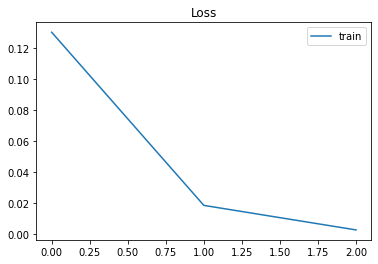

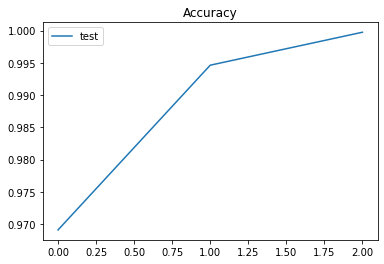

In [24]:
import matplotlib.pyplot as plt


plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show();

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='test')
plt.legend()
plt.show();


In [25]:
# Test for single review 
new_review = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_review)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)


print(pred)
print(np.argmax(pred))

[[0.28729853 0.71270144]]
1


In [26]:
# VISUALIZE THE EMBEDDINGS
from sklearn.manifold import TSNE
import plotly.offline as plotly
import plotly.graph_objs as pltgo
#plotly.init_notebook_mode(connected = True)

words = [] 
for word, i in tokenizer.word_index.items():
  words.append(word)

def plot_words(data, start, stop, step):
  trace = pltgo.Scatter(
      x = data[start:stop:step,0],
      y = data[start:stop:step,1],
      mode = 'markers',
      text = words[start:stop:step]
  )
  layout = dict(title = 't-SNE 1 vs t-SNE 2',
                yaxis = dict(title = 't-SNE 2'),
                xaxis = dict(title = 't-SNE 1'),
                hovermode = 'closest')
  fig = dict(data=[trace], layout = layout)
  pyotly.iplot(fig)  

model_embeddings = model.layers[0].get_weights()[0]
lstm_embeds = TSNE(n_components =2, verbose=10).fit_transform(model_embeddings)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 50000 samples in 1.750s...
[t-SNE] Computed neighbors for 50000 samples in 1396.322s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for 

In [27]:
plot_words(lstm_embeds, 0, MAX_VOCAB_SIZE, 1)

NameError: ignored